# Overview

This exercise demonstrates how TEMPO data can be used to track and assess ozone precursors and ozone formation potential, in support of assessing ozone exceedances.

**Notebook Author / Affiliation**

* Author: Carl Malings / NASA ARSET
* This notebook is based on examples from the [ASDC Data and User Services Github](https://github.com/nasa/ASDC_Data_and_User_Services).

## Package Installation and Setup

*Instructions*

* Run the cell below to install the non-standard packages required for this exercise.

*NOTE: This also includes the pyrisg package, in addition to those used in previous exercises*

In [ ]:
!pip install --quiet harmony-py cartopy pyrsig

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.8 MB/s eta 0:00:00


*Instructions*

* Run the code cell below to import the required packages.

In [ ]:
# Downloading TEMPO data
import datetime as dt
import getpass
import os
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

# Opening TEMPO data files
import xarray as xr

# Creating graphics
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

# Downloading AirNow data
import pyrsig

# Working with data tables
import numpy as np
import pandas as pd

# Download TEMPO NO2 and HCHO Data

The first part of this exercise will be to download the TEMPO NO2 and HCHO data for the region and time period of interest.

*Instructions*

* Run the cell below and enter your Earthdata credentials to prepare for data downloading

In [ ]:
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Username:carl_malings
··········


## Get TEMPO Level-3 NO2 Data

The below code is copied from previous examples of downloading TEMPO data. You will use it to download TEMPO Level-3 NO2 data for a region and time period of inerest.

**Region of Interest**: Colorado Front Range (latitude 38 to 41, longitude -106 to -103)

**Time of Interest**: July 27 to 31, 2024

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 NO2 data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `RoI`, `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [ ]:
# This list will save the bounding box limits for later use:
RoI = [-106, 38, -103, 41]

# Structure the request:
request_no2 = Request(
    collection=Collection(id='C2930763263-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2024, 7, 27),
        'stop': dt.datetime(2024, 7, 31)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_no2.is_valid()

True

*Submit and monitor the request*

In [ ]:
job_id_no2 = harmony_client.submit(request_no2)
print(f"jobID = {job_id_no2}")

harmony_client.wait_for_processing(job_id_no2, show_progress=True)

jobID = 0533db39-bc14-4bf7-8eee-15e8ef6eeb56


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [ ]:
download_dir = os.path.expanduser("~/tempo_data_ozone_precursor_exercise")
os.makedirs(download_dir, exist_ok=True)

results_no2 = harmony_client.download_all(job_id_no2, directory=download_dir)
all_results_stored_no2 = [f.result() for f in results_no2]

print(f"Number of files: {len(all_results_stored_no2)}")

/root/tempo_data_ozone_precursor_exercise/106397127_TEMPO_NO2_L3_V03_20240728T103139Z_S001_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397111_TEMPO_NO2_L3_V03_20240727T103122Z_S001_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397112_TEMPO_NO2_L3_V03_20240727T111127Z_S002_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397113_TEMPO_NO2_L3_V03_20240727T115132Z_S003_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397129_TEMPO_NO2_L3_V03_20240728T115149Z_S003_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397115_TEMPO_NO2_L3_V03_20240727T131142Z_S005_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397116_TEMPO_NO2_L3_V03_20240727T135147Z_S006_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397108_TEMPO_NO2_L3_V03_20240726T233137Z_S016_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397110_TEMPO_NO2_L3_V03_20240727T005147Z_S018_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397117_TEM

*Open the files and combine into a single Dataset*

<details>

Note that there is a slightly different structure to this code than seen in previous examples. The dictionary `variables_to_keep_and_rename` provides a complete list of the variables to keep and the new names they will be assigned. This makes it more straightforward to change what variables are kept, so that the same code can be re-used more easily for the other TEMPO products.

</details>

In [ ]:
# Define which variables to keep and rename:
variables_to_keep_and_rename = {'product/vertical_column_troposphere':'no2_vertical_column_troposphere',
                                'product/main_data_quality_flag':'no2_qc_flag',
                                'geolocation/solar_zenith_angle':'no2_sza',
                                'support_data/eff_cloud_fraction':'no2_cloud_fraction'
                                }

# Create a dictionary to store the data:
data_dictionary = {variable:[] for variable in variables_to_keep_and_rename.keys()}

# Loop through the result files:
for result_file in sorted(all_results_stored_no2):
    # Loop throuch variables:
    for variable in variables_to_keep_and_rename.keys():
        # For each file and variable, add the data from that file to the appropriate list in the dictionary:
        data_dictionary[variable] += [xr.open_datatree(result_file)[variable]]

# Concatenate each list into a Dataset along the time dimenion:
for variable in variables_to_keep_and_rename.keys():
    data_dictionary[variable] = xr.concat(data_dictionary[variable],dim='time')

# Merge the Datasets together:
tempo_data_no2 = xr.merge([data_dictionary[variable] for variable in variables_to_keep_and_rename.keys()])

# Rename the variables
tempo_data_no2 = tempo_data_no2.rename({variable.split('/')[1]:variables_to_keep_and_rename[variable] for variable in variables_to_keep_and_rename.keys()})

# Examine the result:
tempo_data_no2

<xarray.Dataset> Size: 31MB
Dimensions:                          (longitude: 150, latitude: 150, time: 68)
Coordinates:
  * longitude                        (longitude) float32 600B -106.0 ... -103.0
  * latitude                         (latitude) float32 600B 38.01 ... 40.99
  * time                             (time) datetime64[ns] 544B 2024-07-26T23...
Data variables:
    no2_vertical_column_troposphere  (time, latitude, longitude) float64 12MB ...
    no2_qc_flag                      (time, latitude, longitude) float32 6MB ...
    no2_sza                          (time, latitude, longitude) float32 6MB ...
    no2_cloud_fraction               (time, latitude, longitude) float32 6MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

*Apply quality control*

<details>

For this exercise, we will accept Suspect data, and also filter by Solar Zenith Angle (accepting values less than 80) and Cloud Fraction (accepting values less than 0.2)

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [ ]:
filter_qa = tempo_data_no2['no2_qc_flag'] <= 1
filter_sza = tempo_data_no2['no2_sza'] < 80
filter_cf = tempo_data_no2['no2_cloud_fraction'] < 0.2

tempo_data_no2_filtered = tempo_data_no2.where(filter_qa & filter_sza & filter_cf).squeeze()

## Get TEMPO Level-3 HCHO Data

The below code is copied from previous examples of downloading TEMPO data. You will use it to download TEMPO Level-3 HCHO data for a region and time period of inerest.

**Region of Interest**: Colorado Front Range (latitude 38 to 41, longitude -106 to -103)

**Time of Interest**: July 27 to 31, 2024

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 HCHO data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `RoI`, `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [ ]:
# Structure the request:
request_hcho = Request(
    collection=Collection(id='C2930761273-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2024, 7, 27),
        'stop': dt.datetime(2024, 7, 31)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_hcho.is_valid()

True

*Submit and monitor the request*

In [ ]:
job_id_hcho = harmony_client.submit(request_hcho)
print(f"jobID = {job_id_hcho}")

harmony_client.wait_for_processing(job_id_hcho, show_progress=True)

jobID = ef3a467e-f7a9-4cc3-8c7a-2c33962c738f


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [ ]:
results_hcho = harmony_client.download_all(job_id_hcho, directory=download_dir)
all_results_stored_hcho = [f.result() for f in results_hcho]

print(f"Number of files: {len(all_results_stored_hcho)}")

/root/tempo_data_ozone_precursor_exercise/106397255_TEMPO_HCHO_L3_V03_20240727T001142Z_S017_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397254_TEMPO_HCHO_L3_V03_20240726T233137Z_S016_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397256_TEMPO_HCHO_L3_V03_20240727T005147Z_S018_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397257_TEMPO_HCHO_L3_V03_20240727T103122Z_S001_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397258_TEMPO_HCHO_L3_V03_20240727T111127Z_S002_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397260_TEMPO_HCHO_L3_V03_20240727T123137Z_S004_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397259_TEMPO_HCHO_L3_V03_20240727T115132Z_S003_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397261_TEMPO_HCHO_L3_V03_20240727T131142Z_S005_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/106397264_TEMPO_HCHO_L3_V03_20240727T175147Z_S009_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/1063

*Open the files and combine into a single Dataset*

In [ ]:
# Define which variables to keep and rename:
variables_to_keep_and_rename = {'product/vertical_column':'hcho_vertical_column',
                                'product/main_data_quality_flag':'hcho_qc_flag',
                                'geolocation/solar_zenith_angle':'hcho_sza',
                                'support_data/eff_cloud_fraction':'hcho_cloud_fraction'
                                }

# Create a dictionary to store the data:
data_dictionary = {variable:[] for variable in variables_to_keep_and_rename.keys()}

# Loop through the result files:
for result_file in sorted(all_results_stored_hcho):
    # Loop throuch variables:
    for variable in variables_to_keep_and_rename.keys():
        # For each file and variable, add the data from that file to the appropriate list in the dictionary:
        data_dictionary[variable] += [xr.open_datatree(result_file)[variable]]

# Concatenate each list into a Dataset along the time dimenion:
for variable in variables_to_keep_and_rename.keys():
    data_dictionary[variable] = xr.concat(data_dictionary[variable],dim='time')

# Merge the Datasets together:
tempo_data_hcho = xr.merge([data_dictionary[variable] for variable in variables_to_keep_and_rename.keys()])

# Rename the variables
tempo_data_hcho = tempo_data_hcho.rename({variable.split('/')[1]:variables_to_keep_and_rename[variable] for variable in variables_to_keep_and_rename.keys()})

# Examine the result:
tempo_data_hcho

<xarray.Dataset> Size: 31MB
Dimensions:               (longitude: 150, latitude: 150, time: 68)
Coordinates:
  * longitude             (longitude) float32 600B -106.0 -106.0 ... -103.0
  * latitude              (latitude) float32 600B 38.01 38.03 ... 40.97 40.99
  * time                  (time) datetime64[ns] 544B 2024-07-26T23:31:55.1483...
Data variables:
    hcho_vertical_column  (time, latitude, longitude) float64 12MB 4.788e+16 ...
    hcho_qc_flag          (time, latitude, longitude) float32 6MB 0.0 ... 0.0
    hcho_sza              (time, latitude, longitude) float32 6MB 63.52 ... 3...
    hcho_cloud_fraction   (time, latitude, longitude) float32 6MB 0.9461 ... ...
Attributes:
    long_name:  formaldehyde vertical column
    comment:    formaldehyde vertical column determined from fitted slant col...
    units:      molecules/cm^2

*Apply quality control*

<details>

For this exercise, we will accept Suspect data, and also filter by Solar Zenith Angle (accepting values less than 80) and Cloud Fraction (accepting values less than 0.2)

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [ ]:
filter_qa = tempo_data_hcho['hcho_qc_flag'] <= 1
filter_sza = tempo_data_hcho['hcho_sza'] < 70
filter_cf = tempo_data_hcho['hcho_cloud_fraction'] < 0.2

tempo_data_hcho_filtered = tempo_data_hcho.where(filter_qa & filter_sza & filter_cf).squeeze()

## Combine into a single TEMPO Dataset

To facilitate analysis, it will help if all the data are in one dataset.

*Instructions*

* Write code to merge the quality-controlled datasets together into one.

* Write code to merge the original datasets (without quality control filters applied) into one.

<details>

*Hint*: To merge datasets together, use the following code example:

```
merged_dataset = xr.merge([dataset_1,dataset_2])
```


</details>

In [ ]:
# Merge the quality-controlled datasets together:
tempo_data_filtered = xr.merge([tempo_data_no2_filtered,tempo_data_hcho_filtered])

# Merge the original datasets together:
tempo_data = xr.merge([tempo_data_no2,tempo_data_hcho])

# Examine the results:
tempo_data

<xarray.Dataset> Size: 61MB
Dimensions:                          (longitude: 150, latitude: 150, time: 68)
Coordinates:
  * longitude                        (longitude) float32 600B -106.0 ... -103.0
  * latitude                         (latitude) float32 600B 38.01 ... 40.99
  * time                             (time) datetime64[ns] 544B 2024-07-26T23...
Data variables:
    no2_vertical_column_troposphere  (time, latitude, longitude) float64 12MB ...
    no2_qc_flag                      (time, latitude, longitude) float32 6MB ...
    no2_sza                          (time, latitude, longitude) float32 6MB ...
    no2_cloud_fraction               (time, latitude, longitude) float32 6MB ...
    hcho_vertical_column             (time, latitude, longitude) float64 12MB ...
    hcho_qc_flag                     (time, latitude, longitude) float32 6MB ...
    hcho_sza                         (time, latitude, longitude) float32 6MB ...
    hcho_cloud_fraction              (time, latitude, longitude) float32 6MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

# Plotting NO2 and HCHO for different times and time intervals



We will now create plots of NO2 and HCHO for the event, examining the effects of changing the averaging time and cloud fraction filtering.

*Instructuions*

* Run the cell below to define the data projection and the mapping function.

In [ ]:
data_proj = ccrs.PlateCarree()

def make_nice_map(axis):
    axis.add_feature(cfeature.STATES.with_scale('50m'), edgecolor="black", linewidth=0.5)
    roads = cfeature.NaturalEarthFeature(
        category="cultural",
        name="roads",
        scale="10m",
        facecolor="none",
    )
    axis.add_feature(roads, linestyle="--", edgecolor="grey", linewidth=0.5)
    axis.coastlines(resolution="50m", color="black", linewidth=1.0)

    axis.set_extent([RoI[0], RoI[2], RoI[1], RoI[3]], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

## Plot Datasets for a Single Timestamp

The code below is taken from earlier plotting examples, with slight modifications. It is meant to plot the NO2 and HCHO data side-by-side, for a single time.

*Instructions*

* Identify where the code is getting its data inputs for NO2 and HCHO. Modify this to the filtered dataset you created earlier.

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

<details>

*Hint*: The code assumes the data are coming from a `tempo_data_filtered` Dataset.

</details>

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_roads.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


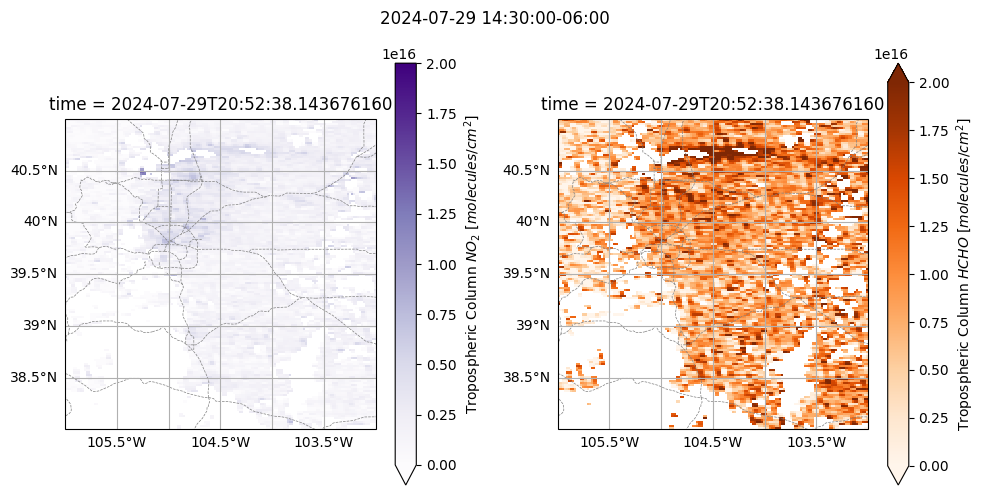

In [ ]:
# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2024-07-29 14:30:00',tz='America/Denver')

# Convert the timestamp from local time to UTC:
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot_no2 = tempo_data_filtered['no2_vertical_column_troposphere'].sel(time=timestamp_utc,method='nearest')
data_to_plot_hcho = tempo_data_filtered['hcho_vertical_column'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={"projection": data_proj})

make_nice_map(ax[0])

data_to_plot_no2.plot(
    ax=ax[0], # axis to add plot to
    cmap=plt.get_cmap('Purples'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $NO_2$ [$molecules/cm^2$]'} # set colorbar label
)

make_nice_map(ax[1])

data_to_plot_hcho.plot(
    ax=ax[1], # axis to add plot to
    cmap=plt.get_cmap('Oranges'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $HCHO$ [$molecules/cm^2$]'} # set colorbar label
)

fig.suptitle(timestamp_local)
plt.tight_layout()
plt.show()

## Try Changing the Quality Control

In the above plots, some of the densest parts of the plumes are missing. Aggressively filtering based on the cloud fraction can also remove thick smoke. To reduce this issue, we will apply a less strict quality control filter for the effective cloud fraction.

*Instructions*

* Revisit the combined dataset without filtering you created above.

* Apply new quality control filters to that dataset to create a new filtered dataset. Specifically, we will accept Suspect data, filter by Solar Zenith Angle (accepting values less than 80), and Cloud Fraction (now accepting values less than 0.5, rahter than 0.2).

<details>

*Hint*: You can create a dataset which acts as a binary filtering mask by setting it equal to a logical expression, such as an inequality. For example:

```
binary_mask = data <= threshold
```

`binary_mask` will have value `True` wherever the values in `data` are less than or equal to `threshold`. You can use this to mask out data from the dataset. For example:

```
maksed_data = data.where(mask).squeeze()
```

`masked_data` will contain the values in `data` where the `mask` is `True`, and will be `NaN` otherwise.

*Hint*: You can use the logical expression `&` to combine multiple binary masks. For example:

```
data_masked_by_a_and_b = data.where(mask_a & mask_b).squeeze()
```

*Hint*: Revisit the quality controls applied when the data were first downloaded for additional examples.

</details>

In [ ]:
filter_qa_no2 = tempo_data['no2_qc_flag'] <= 1
filter_qa_hcho = tempo_data['no2_qc_flag'] <= 1
filter_sza = tempo_data['no2_sza'] < 80
filter_cf = tempo_data['no2_cloud_fraction'] < 0.5

tempo_data_refiltered = tempo_data.where(filter_qa_no2 & filter_qa_hcho & filter_sza & filter_cf).squeeze()

Now, we will re-plot the figures for a single timestamp.

*Instructions*

* Identify where the code is getting its data inputs for NO2 and HCHO. Modify this to the newly filtered dataset you just created.

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

<details>

*Hint*: The code assumes the data are coming from a `tempo_data_refiltered` Dataset.

</details>

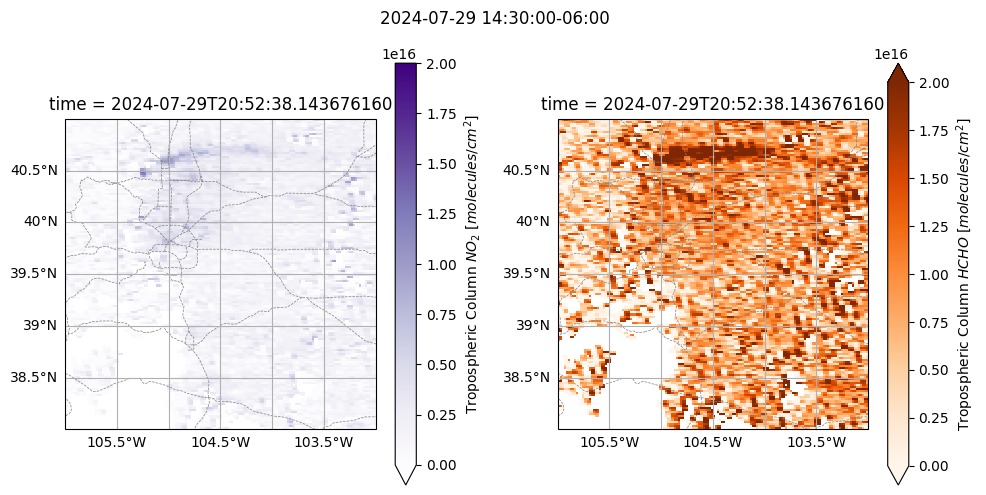

In [ ]:
# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2024-07-29 14:30:00',tz='America/Denver')

# Convert the timestamp from local time to UTC:
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot_no2 = tempo_data_refiltered['no2_vertical_column_troposphere'].sel(time=timestamp_utc,method='nearest')
data_to_plot_hcho = tempo_data_refiltered['hcho_vertical_column'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={"projection": data_proj})

make_nice_map(ax[0])

data_to_plot_no2.plot(
    ax=ax[0], # axis to add plot to
    cmap=plt.get_cmap('Purples'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $NO_2$ [$molecules/cm^2$]'} # set colorbar label
)

make_nice_map(ax[1])

data_to_plot_hcho.plot(
    ax=ax[1], # axis to add plot to
    cmap=plt.get_cmap('Oranges'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $HCHO$ [$molecules/cm^2$]'} # set colorbar label
)

fig.suptitle(timestamp_local)
plt.tight_layout()
plt.show()

## Plot Datasets Averaged for Multiple Timestamps

Plots at single timesteps can be noisy, and have missing data. To reduce some of these data gaps and smooth out noise, we can average across multiple timesteps.

*Instructions*

* Write code to define the `data_to_plot_no2` and `data_to_plot_hcho` variables.

  * `data_to_plot_no2` should be the average of your newly filtered NO2 tropospheric column data between `timestamp_utc_start` and `timestamp_utc_stop`

  * `data_to_plot_hcho` should be the average of your newly filtered HCHO column data between `timestamp_utc_start` and `timestamp_utc_stop`

* Run the cell and check the output.

* Try picking different starting and ending times for the averaging period and examining the output.

<details>

*Hint*: This example code will average the values of `data` between `start_time` and `stop_time`:

```
time_average_data = data.sel(time=slice(start_time,stop_time)).mean('time')
```


</details>

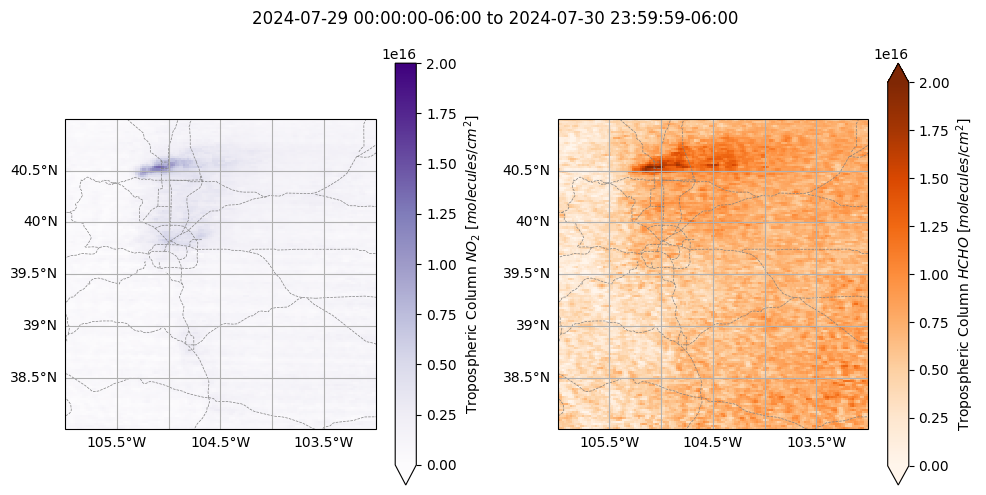

In [ ]:
# Choose a timestamp to plot:
timestamp_local_start = pd.Timestamp('2024-07-29 00:00:00',tz='America/Denver')
timestamp_local_stop = pd.Timestamp('2024-07-30 23:59:59',tz='America/Denver')

# Convert the timestamp from local time to UTC:
timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC').to_datetime64()
timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot_no2 = tempo_data_refiltered['no2_vertical_column_troposphere'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')
data_to_plot_hcho = tempo_data_refiltered['hcho_vertical_column'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')

# Plot the data on a map:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={"projection": data_proj})

make_nice_map(ax[0])

data_to_plot_no2.plot(
    ax=ax[0], # axis to add plot to
    cmap=plt.get_cmap('Purples'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $NO_2$ [$molecules/cm^2$]'} # set colorbar label
)

make_nice_map(ax[1])

data_to_plot_hcho.plot(
    ax=ax[1], # axis to add plot to
    cmap=plt.get_cmap('Oranges'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $HCHO$ [$molecules/cm^2$]'} # set colorbar label
)

fig.suptitle(f'{timestamp_local_start} to {timestamp_local_stop}')
plt.tight_layout()
plt.show()

## Create Daily-Average Plots

Plots averaged over about a day are relatively smooth and complete. We will plot a series of daily-averaged maps of NO2 and HCHO.

*Instructions*

* The code below has been set up to plot daily averages for a sequence of days, defined by `days_to_plot`. Check that `days_to_plot` starts on the correct day and has the correct number of days (`periods`) for the time interval of your dataset.

* Copy the code you created above to define the `data_to_plot_no2` and `data_to_plot_hcho` variables.

* Run the cell and check the outputs.

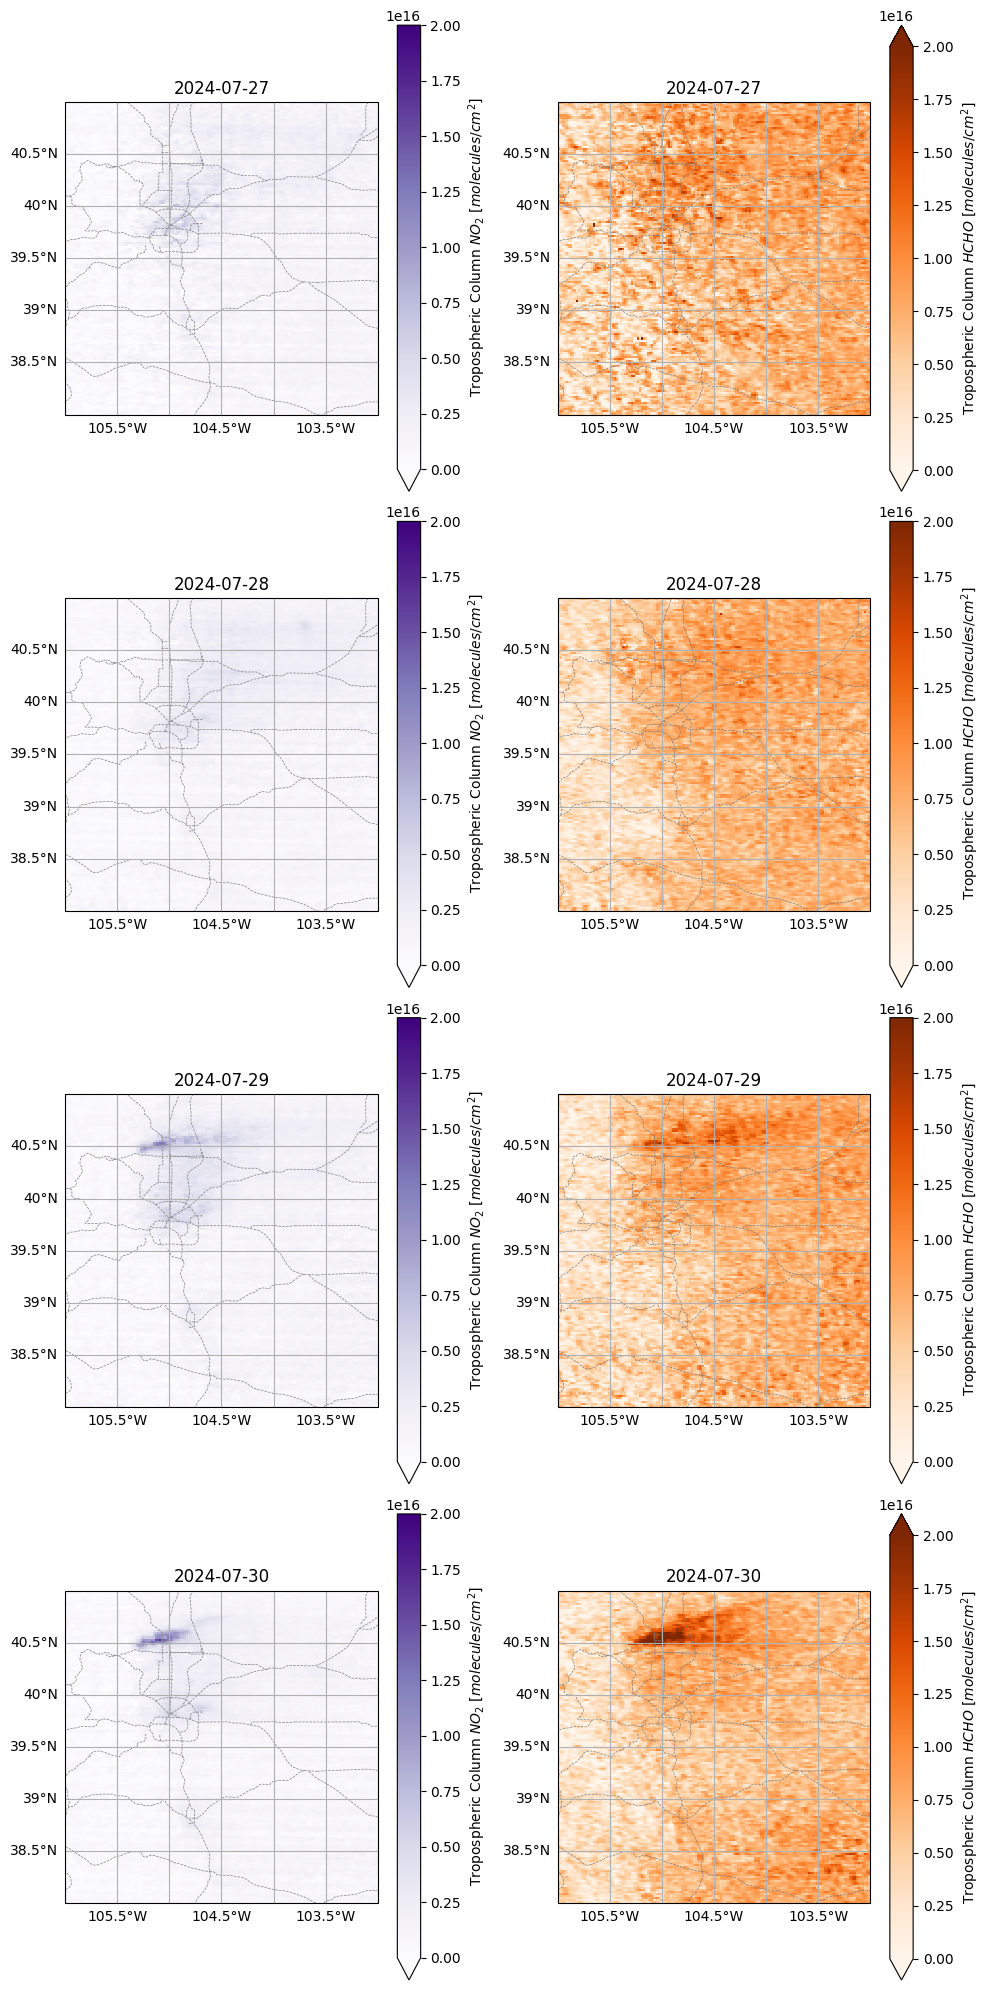

In [ ]:
# Define a sequence of days to plot:
days_to_plot = pd.date_range("2024-07-27", periods=4, freq="D", tz='America/Denver')

# Create the figure
fig, ax = plt.subplots(nrows=len(days_to_plot), ncols=2, figsize=(10, 5*len(days_to_plot)), subplot_kw={"projection": data_proj})

for day_index,day_timestamp in enumerate(days_to_plot):
    # Choose a timestamp to plot:
    timestamp_local_start = day_timestamp
    timestamp_local_stop = day_timestamp + pd.Timedelta(days=1)

    # Convert the timestamp from local time to UTC:
    timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC').to_datetime64()
    timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC').to_datetime64()

    # Select the data to plot:
    data_to_plot_no2 = tempo_data_refiltered['no2_vertical_column_troposphere'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')
    data_to_plot_hcho = tempo_data_refiltered['hcho_vertical_column'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')

    # Plot the data on a map:
    make_nice_map(ax[day_index,0])

    data_to_plot_no2.plot(
        ax=ax[day_index,0], # axis to add plot to
        cmap=plt.get_cmap('Purples'), # color scale
        vmin=0, # minimum value
        vmax=20e15, # maximum value
        cbar_kwargs={'label':'Tropospheric Column $NO_2$ [$molecules/cm^2$]'} # set colorbar label
    )

    ax[day_index,0].set_title(timestamp_local_start.date())

    make_nice_map(ax[day_index,1])

    data_to_plot_hcho.plot(
        ax=ax[day_index,1], # axis to add plot to
        cmap=plt.get_cmap('Oranges'), # color scale
        vmin=0, # minimum value
        vmax=20e15, # maximum value
        cbar_kwargs={'label':'Tropospheric Column $HCHO$ [$molecules/cm^2$]'} # set colorbar label
    )

    ax[day_index,1].set_title(timestamp_local_start.date())

plt.tight_layout()
plt.show()

## Analyse the Formaldehyde-to-NO2 Ratios

Finally, will can assess the Formaldehyde-to-NO2 ratios as a potential indicator of the causes of ozone formation. The code below is similar to the above, and is intended to plot daily averages of a variable `data_to_plot_fnr`, which you need to define.

*Instructions*

* Copy the code you created above to define the `data_to_plot_no2` and `data_to_plot_hcho` variables.

* Add code to define `data_to_plot_fnr` as the ratio of `data_to_plot_hcho` and `data_to_plot_no2`.

* Run the cell and check the outputs.

<details>

*Hint*: The formula for a ratio in python is: `ratio = numerator/denominator`

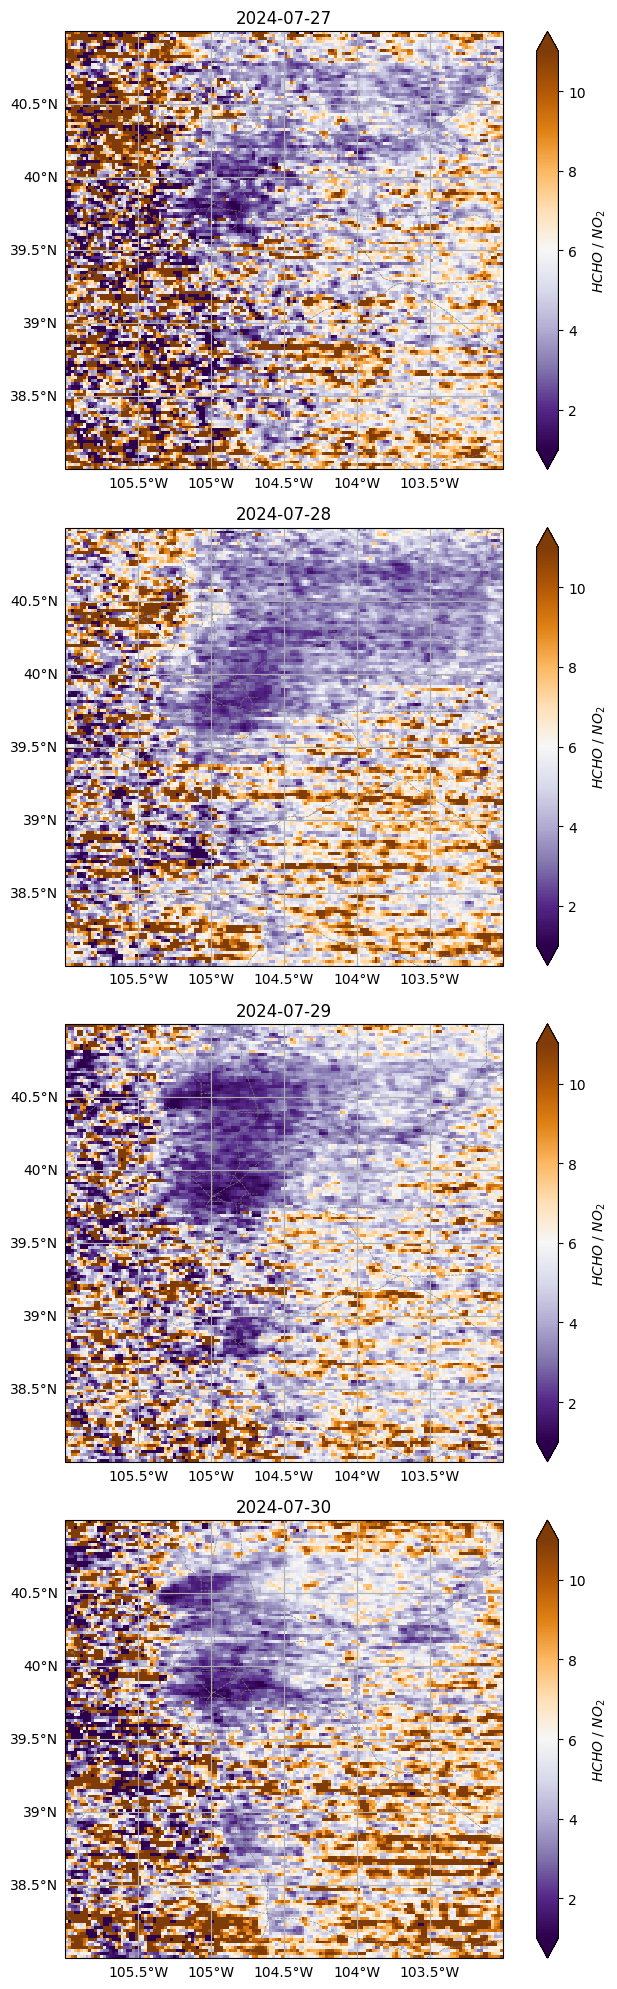

In [ ]:
# Define a sequence of days to plot:
days_to_plot = pd.date_range("2024-07-27", periods=4, freq="D", tz='America/Denver')

# Create the figure
fig, ax = plt.subplots(nrows=len(days_to_plot), ncols=1, figsize=(7, 5*len(days_to_plot)), subplot_kw={"projection": data_proj})

for day_index,day_timestamp in enumerate(days_to_plot):
    # Choose a timestamp to plot:
    timestamp_local_start = day_timestamp
    timestamp_local_stop = day_timestamp + pd.Timedelta(days=1)

    # Convert the timestamp from local time to UTC:
    timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC').to_datetime64()
    timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC').to_datetime64()

    # Select the data to plot:
    data_to_plot_no2 = tempo_data_refiltered['no2_vertical_column_troposphere'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')
    data_to_plot_hcho = tempo_data_refiltered['hcho_vertical_column'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')
    data_to_plot_fnr = data_to_plot_hcho/data_to_plot_no2

    # Plot the data on a map:
    make_nice_map(ax[day_index])

    data_to_plot_fnr.plot(
        ax=ax[day_index], # axis to add plot to
        cmap=plt.get_cmap('PuOr_r'), # color scale
        vmin=1, # minimum value
        vmax=11, # maximum value
        cbar_kwargs={'label':'$HCHO$ / $NO_2$'} # set colorbar label
    )

    ax[day_index].set_title(timestamp_local_start.date())

plt.tight_layout()
plt.show()

# Bonus: Compare with AirNow Ozone Monitor Data

We can add the surface ozone monitor data into our plots for additional context.

## Use pyrsig to download AirNow ozone

We will use the [pyrsig package](https://barronh.github.io/pyrsig/) to easily bring the AirNow ozone data into python. Below is a template for how a query is structured and submitted to pyrsig. The result will be a data table with the ozone data, timestamps, and station information.

*Instructions*

* Modify the template to have the approrpiate start end and dates.

* Modify the template to have the appropriate bounding box for the region of interest.

* Run the cell to examine the output table.

In [ ]:
# Define the query for pyrisg:
api = pyrsig.RsigApi(bdate="2024-07-27", # start date of the query, in the format "YYYY-MM-DD"
                     edate="2024-07-31", # end date of the query, in the format "YYY-MM-DD"
                     bbox=(RoI[0],RoI[1],RoI[2],RoI[3]), # bounding box for the query, in the format (minimum_longitude,minimum_latitude,maximum_longitude,maximum_latitude)
                     workdir=download_dir, # temporary directory to store the downloaded data
                     gridfit=True) # data are not being re-aligned to a grid
airnowkey = "airnow.ozone" # this is the pyrsig code to specify ozone data from AirNow

# Execute the query to download the data:
airnow_data = api.to_dataframe(airnowkey, unit_keys=False, parse_dates=True)

# Examine the resulting table:
airnow_data

,Timestamp,LONGITUDE,LATITUDE,STATION,ozone,SITE_NAME,time
0,2024-07-27T00:00:00-0000,-104.94890,39.83920,7703,64.0,840080013001;44201,2024-07-27 00:00:00+00:00
1,2024-07-27T00:00:00-0000,-104.95720,39.56890,7705,49.0,840080050002;44201,2024-07-27 00:00:00+00:00
2,2024-07-27T00:00:00-0000,-104.56906,39.63854,7707,66.0,840080050006;44201,2024-07-27 00:00:00+00:00
3,2024-07-27T00:00:00-0000,-105.22023,40.07001,7713,60.0,840080130014;44201,2024-07-27 00:00:00+00:00
4,2024-07-27T00:00:00-0000,-104.98720,39.75110,7717,63.0,840080310002;44201,2024-07-27 00:00:00+00:00
...,...,...,...,...,...,...,...
1928,2024-07-31T00:00:00-0000,-104.94999,40.51508,7750,60.0,840080690016;44201,2024-07-31 00:00:00+00:00
1929,2024-07-31T00:00:00-0000,-105.07940,40.57640,7751,52.0,840080691004;44201,2024-07-31 00:00:00+00:00
1930,2024-07-31T00:00:00-0000,-104.72250,38.30333,7768,55.0,840081010016;44201,2024-07-31 00:00:00+00:00
1931,2024-07-31T00:00:00-0000,-104.73670,40.38610,7775,68.0,840081230009;44201,2024-07-31 00:00:00+00:00


## Map Comparison Plot

Finally, we will overlay ozone monitor averages onto an Formaldehyde-to-NO2 ratio map. The code example below should generate this plot, but again, it assumes the data are in specifically named datasets which might not exist in your run of the code.

*Instructions*

* Examine the code and see if you can understand what is happening in each part.

* Try to run the code below, troubleshooting any errors you encounter.

* Try changing the axis limits on the ozone plot colorbar.

<details>

*Hint*: If youn are getting errors, try copying subsets of the code into a new cell to run it incrementally, and see where the errors are coming from. Put the name of a variable in a cell by itself and run that cell to see what the variable looks like.

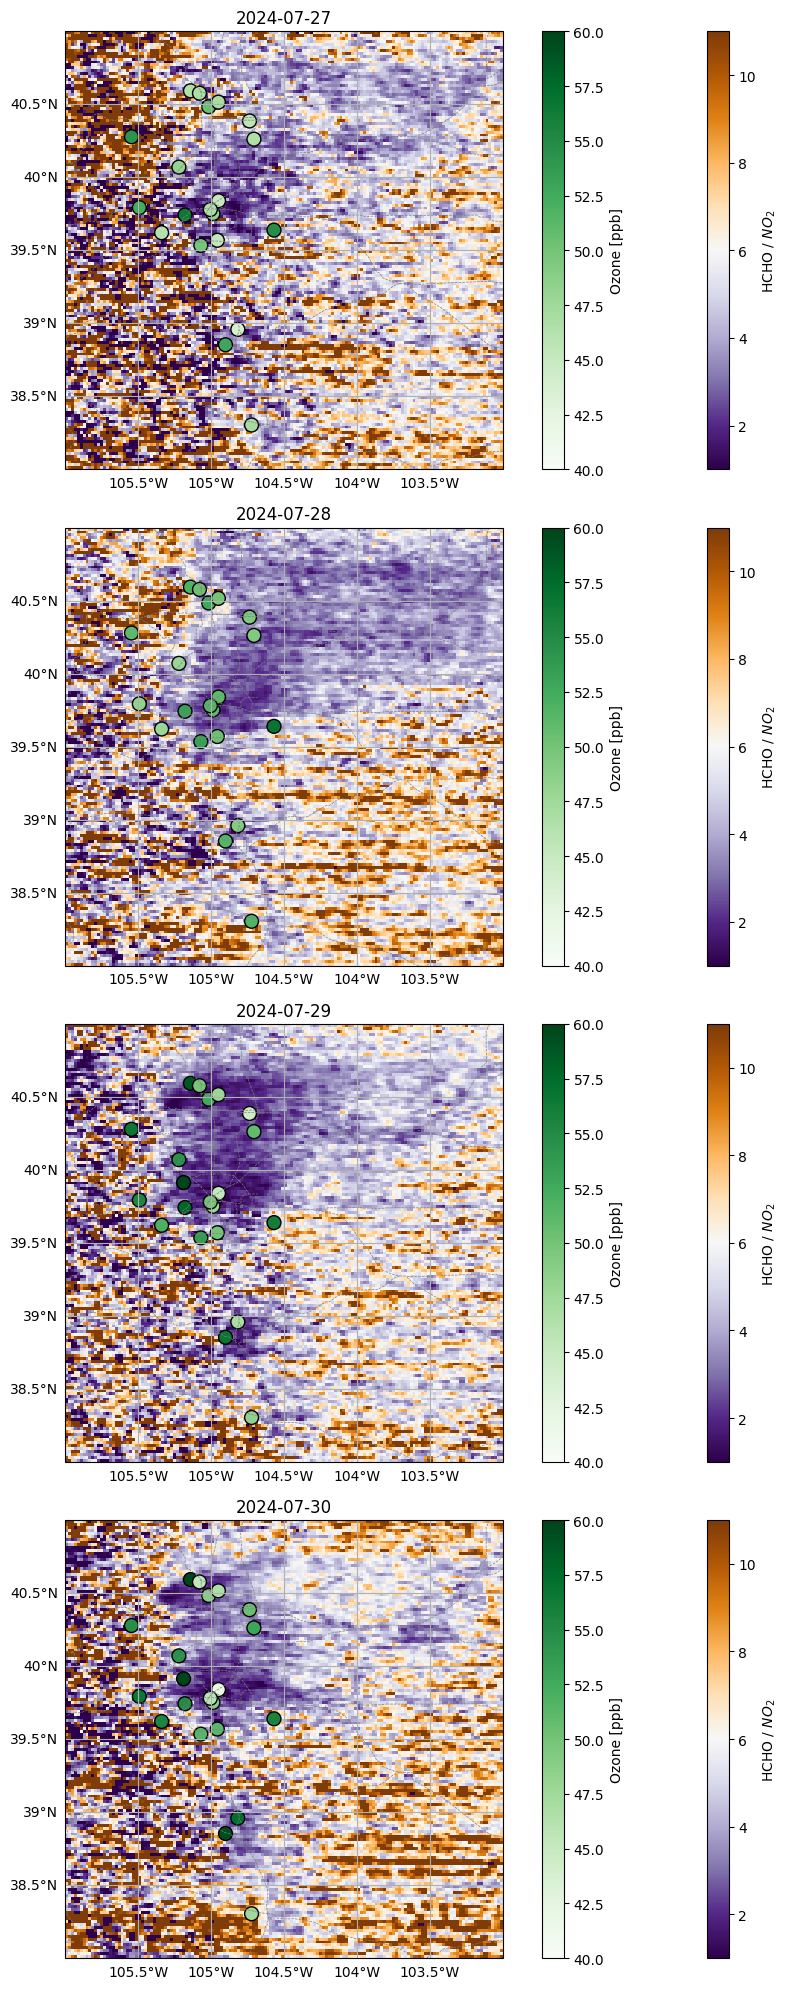

In [ ]:
# Define a sequence of days to plot:
days_to_plot = pd.date_range("2024-07-27", periods=4, freq="D", tz='America/Denver')

# Create the figure
fig, ax = plt.subplots(nrows=len(days_to_plot), ncols=1, figsize=(10, 5*len(days_to_plot)), subplot_kw={"projection": data_proj})

for day_index,day_timestamp in enumerate(days_to_plot):
    # Choose a timestamp to plot:
    timestamp_local_start = day_timestamp
    timestamp_local_stop = day_timestamp + pd.Timedelta(days=1)

    # Convert the timestamp from local time to UTC:
    timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC').to_datetime64()
    timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC').to_datetime64()

    # Select the data to plot:
    data_to_plot_no2 = tempo_data_refiltered['no2_vertical_column_troposphere'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')
    data_to_plot_hcho = tempo_data_refiltered['hcho_vertical_column'].sel(time=slice(timestamp_utc_start,timestamp_utc_stop)).mean('time')
    data_to_plot_fnr = data_to_plot_hcho/data_to_plot_no2

    # Subset the AirNow ozone data to plot:
    airnow_data_subset = airnow_data.where((airnow_data['time'] >= pd.Timestamp(timestamp_utc_start,tz='UTC')) & (airnow_data['time'] < pd.Timestamp(timestamp_utc_stop,tz='UTC'))).dropna(how='all')

    # Compute the average:
    average_ozone_to_plot = airnow_data_subset[['STATION','LATITUDE','LONGITUDE','ozone']].groupby('STATION').mean()

    # Plot the data on a map:
    make_nice_map(ax[day_index])

    ratio_plot = data_to_plot_fnr.plot(
        ax=ax[day_index], # axis to add plot to
        cmap=plt.get_cmap('PuOr_r'), # color scale
        vmin=1, # minimum value
        vmax=11, # maximum value
        add_colorbar=False
    )

    colorbar_ratio = plt.colorbar(ratio_plot)
    colorbar_ratio.set_label('HCHO / $NO_2$')

    ozone_plot = ax[day_index].scatter(average_ozone_to_plot['LONGITUDE'],
                            average_ozone_to_plot['LATITUDE'],
                            s=100,
                            c=average_ozone_to_plot['ozone'],
                            cmap=plt.get_cmap('Greens'),
                            vmin=40,
                            vmax=60,
                            edgecolors='black')

    colorbar_ozone = plt.colorbar(ozone_plot)
    colorbar_ozone.set_label('Ozone [ppb]')

    ax[day_index].set_title(timestamp_local_start.date())

plt.tight_layout()
plt.show()
